# SqueezeNet 

In [2]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import tensorflow as tf

In [3]:
def squeezeNet(input_shape, n_classes):
    def fire(x_in, n_squeeze, n_expand):
        x_sqeeze = tf.keras.layers.Conv2D(n_squeeze, 1, activation="relu")(x_in)
        x_expand1 = tf.keras.layers.Conv2D(n_expand, 1, activation="relu")(x_sqeeze)
        x_expand3 = tf.keras.layers.Conv2D(n_expand, 3, padding ="same", activation="relu")(x_sqeeze)
        output = tf.keras.layers.concatenate([x_expand1, x_expand3])
        return output
    inn = tf.keras.Input(input_shape) # size of your pictures
    x = tf.keras.layers.Conv2D(96, 7, strides=2, padding ="same", activation="relu")(inn)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 16, 64)
    x = fire(x, 16, 64)
    x = fire(x, 32, 128)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 32, 128)
    x = fire(x, 48, 192)
    x = fire(x, 48, 192)
    x = fire(x, 64, 256)
    x = tf.keras.layers.MaxPool2D(3, strides=2, padding ="same")(x)
    x = fire(x, 64, 256)
    x = tf.keras.layers.Conv2D(n_classes, 1)(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    output = tf.keras.layers.Activation("softmax")(x)
    model = tf.keras.models.Model(inn, output)
    return model

# Cifar10

In [ ]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3

In [ ]:
# get the data
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# do a 1hot encoding on labels
y_train = tf.keras.utils.to_categorical(y_train, N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, N_CLASSES)

In [ ]:
# check if data shapes are correct
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [ ]:
# augment pictures
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)

In [ ]:
# clear old models and create new squeezeNet
tf.keras.backend.clear_session()
model = squeezeNet(INSHAPE, N_CLASSES)
# chekout squeezeNet architecture
#model.summary()

In [ ]:
# training configuration
model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
# generator for data augmentation with 64 pictures per step generated
it_train = datagen.flow(x_train, y_train, batch_size=64)
steps = x_train.shape[0] // 64 # total steps needed to iterate all pictures

In [1]:
# start training
history = model.fit(it_train, 
                    epochs=100, steps_per_epoch = steps,
                    validation_data=(x_test, y_test), validation_steps = 200 , 
                    verbose=1)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

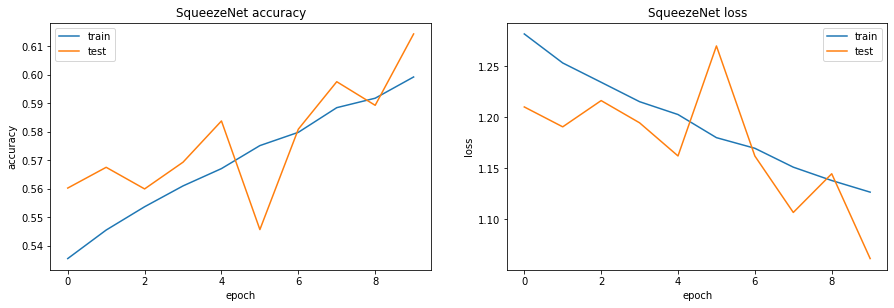

In [ ]:
plot_accuracy_and_loss(history)

# Tiny ImageNet

In [28]:
# TinyIageNet has 200 classes
N_CLASSES = 200
# our input dimensions
INSHAPE = 64, 64, 3
PICTURE_SHAPE = INSHAPE[0], INSHAPE[1]

In [24]:
import numpy as np
import tensorflow as tf
import random

In [25]:
# Fixing the random seed for involved libraries
random_seed=4321

np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

In [26]:
# download tiny Imagenet and create folder
import os
import requests
import zipfile

# Retrieve the data
if not os.path.exists(os.path.join('data','tiny-imagenet-200.zip')):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    # Get the file from web
    r = requests.get(url)

    if not os.path.exists('data'):
        os.mkdir('data')
    
    # Write to a file
    with open(os.path.join('data','tiny-imagenet-200.zip'), 'wb') as f:
        f.write(r.content)
else:
    print("The zip file already exists.")
    
if not os.path.exists(os.path.join('data', 'tiny-imagenet-200')):
    with zipfile.ZipFile(os.path.join('data','tiny-imagenet-200.zip'), 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("The extracted data already exists")

The zip file already exists.
The extracted data already exists


In [29]:
from functools import partial
import pickle
from keras.preprocessing.image import ImageDataGenerator

def get_test_labels_df(test_labels_path):
    """ Reading the test data labels for all files in the test set as a data frame """
    test_df = pd.read_csv(test_labels_path, sep='\t', index_col=None, header=None)
    test_df = test_df.iloc[:,[0,1]].rename({0:"filename", 1:"class"}, axis=1)
    return test_df

def get_train_valid_test_data_generators(batch_size, target_size):
    """ Get the training/validation/testing data generators """
    
    # Defining a data-augmenting image data generator and a standard image data generator
    image_gen_aug = ImageDataGenerator(
                    width_shift_range=0.1, 
                    height_shift_range=0.1, 
                    horizontal_flip=True,
                    validation_split=0.1) #d o test train split here
    
    #image_gen = ImageDataGenerator(samplewise_center=False)
    
    # Define a training data generator
    partial_flow_func = partial(
        image_gen_aug.flow_from_directory, 
        directory=os.path.join('data','tiny-imagenet-200', 'train'), 
        target_size=target_size, classes=None,
        class_mode='categorical', batch_size=batch_size, 
        shuffle=True, seed=random_seed)
    
    # Get the training data subset
    train_gen = partial_flow_func(subset='training')
    # Get the validation data subset
    valid_gen = partial_flow_func(subset='validation') 
    
    return train_gen, valid_gen

In [30]:
BATCH_SIZE = 32
# Getting the train,valid, test data generators
train_gen, valid_gen = get_train_valid_test_data_generators(BATCH_SIZE, PICTURE_SHAPE)

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [31]:
def get_steps_per_epoch(n_data, batch_size):
    """ Given the data size and batch size, gives the number of steps to travers the full dataset """
    if n_data%batch_size==0:
        return int(n_data/batch_size)
    else:
        return int(n_data*1.0/batch_size)+1

In [32]:
# clear old models and create new squeezeNet
tf.keras.backend.clear_session()
model = squeezeNet(INSHAPE, N_CLASSES)
# chekout squeezeNet architecture
#model.summary()

In [33]:
# training configuration
loss = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

In [34]:
history = model.fit(
    train_gen, validation_data=valid_gen, 
    steps_per_epoch=get_steps_per_epoch(int(0.9*(500*200)), BATCH_SIZE), 
    validation_steps=get_steps_per_epoch(int(0.1*(500*200)), BATCH_SIZE),
    epochs=10, verbose=1)


Epoch 1/10
2813/2813 [==============================] - 191s 67ms/step - loss: 5.1015 - accuracy: 0.0153 - val_loss: 4.9141 - val_accuracy: 0.0255
Epoch 2/10
2813/2813 [==============================] - 190s 67ms/step - loss: 4.7432 - accuracy: 0.0427 - val_loss: 4.6439 - val_accuracy: 0.0587
Epoch 3/10
2813/2813 [==============================] - 189s 67ms/step - loss: 4.4919 - accuracy: 0.0726 - val_loss: 4.4085 - val_accuracy: 0.0806
Epoch 4/10
 381/2813 [===>..........................] - ETA: 2:31 - loss: 4.3859 - accuracy: 0.0866

KeyboardInterrupt: ignored

# ResNet50 transfer learning

In [1]:
import numpy as np
import pandas as pd 
from tensorflow import keras
import tensorflow as tf

In [2]:
def res50Net_transfer(input_shape, n_classes, frozen_layers=168, final_layers=False):
    # load resnet with given input shape
    input_t = tf.keras.Input(shape=input_shape)
    res_model = tf.keras.applications.ResNet50(include_top=False,
                                              weights="imagenet",
                                              input_tensor=input_t)
    # freeze top layers of resnet
    for layer in res_model.layers[:frozen_layers]:
        layer.trainable =False

    # wrap resnet by sequencial network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, input_shape[:2])))
    model.add(res_model)
    model.add(tf.keras.layers.Flatten())

    if final_layers: # add dense layers if we need more accuracy
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(64, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.5))
        model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    return model

## Cifar10

In [3]:
# Cifar10 has 10 classes
N_CLASSES = 10
# our input dimensions
INSHAPE = 32, 32, 3

In [4]:
# get the data
(x_train,y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
# do a 1hot encoding on labels
y_train = tf.keras.utils.to_categorical(y_train, N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, N_CLASSES)

In [6]:
# check if data shapes are correct
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


In [7]:
# augment pictures
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True)

In [8]:
# clear old models and create new squeezeNet
tf.keras.backend.clear_session()
model = res50Net_transfer(INSHAPE, N_CLASSES, frozen_layers=168, final_layers=False)


In [9]:
model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])
# generator for data augmentation with 64 pictures per step generated
it_train = datagen.flow(x_train, y_train, batch_size=64)
steps = x_train.shape[0] // 64 # total steps needed to iterate all pictures

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
history = model.fit(it_train, epochs=20, verbose=1,steps_per_epoch=steps,
                    validation_data=(x_test, y_test))

Epoch 1/20
781/781 [==============================] - 45s 51ms/step - loss: 2.4085 - accuracy: 0.3211 - val_loss: 1.7925 - val_accuracy: 0.4424
Epoch 2/20
781/781 [==============================] - 38s 49ms/step - loss: 1.7012 - accuracy: 0.4576 - val_loss: 1.5464 - val_accuracy: 0.5009
Epoch 3/20
781/781 [==============================] - 39s 50ms/step - loss: 1.5151 - accuracy: 0.5010 - val_loss: 1.4396 - val_accuracy: 0.5265
Epoch 4/20
781/781 [==============================] - 38s 49ms/step - loss: 1.4147 - accuracy: 0.5290 - val_loss: 1.3767 - val_accuracy: 0.5423
Epoch 5/20
781/781 [==============================] - 38s 49ms/step - loss: 1.3494 - accuracy: 0.5464 - val_loss: 1.3320 - val_accuracy: 0.5558
Epoch 6/20
781/781 [==============================] - 38s 49ms/step - loss: 1.2886 - accuracy: 0.5627 - val_loss: 1.2948 - val_accuracy: 0.5685
Epoch 7/20
781/781 [==============================] - 39s 50ms/step - loss: 1.2519 - accuracy: 0.5734 - val_loss: 1.2722 - val_accuracy:

In [11]:
import matplotlib.pyplot as plt
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ResNet50 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('ResNet50 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

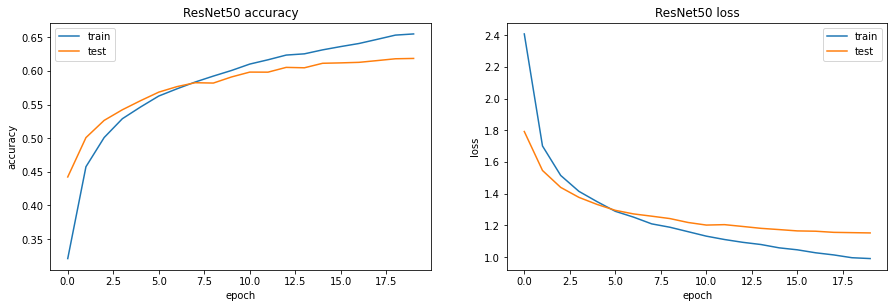

In [12]:
plot_accuracy_and_loss(history)